# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
from scipy import stats
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score , classification_report , accuracy_score , confusion_matrix 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn import metrics 

# Data Cleaning

## Load the dataset
This dataset is taken from the Kaggle page 'https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package/data'.

This dataset comprises about 10 years of daily weather observations from numerous locations across Australia. The observations were gathered from a multitude of weather stations. You can access daily observations from 'http://www.bom.gov.au/climate/data'.

In [2]:
# Load the dataset into a dataframe
df = pd.read_csv('weatherAUS.csv')

## Information about the data
Let's see the first 5 rows of the dataset.

In [3]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Now, we can plot the features of this dataset. In particular, we can understand that the target column is **RainTomorrow**. So, in the *Machine Learning* part we are going to predict this column.

In [4]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

We can print the shape of the dataset

In [5]:
number_of_rows = df.shape[0]
number_of_features = df.shape[1]
print(f'The dataset contains {number_of_rows} rows')
print(f'The dataset contains {number_of_features} columns')

The dataset contains 145460 rows
The dataset contains 23 columns


## Data Cleaning
We can now focus our attention on the data cleaning part in order to discover:
- **NaN values**
- **Outliers**
- **Multicollinearity Problem**

Firstly, we can plot the number of unique values.

In [6]:
for col in df.columns:
    unique_values = df[col].unique()
    print(f"Column '{col}' has {len(unique_values)} unique values")

Column 'Date' has 3436 unique values
Column 'Location' has 49 unique values
Column 'MinTemp' has 390 unique values
Column 'MaxTemp' has 506 unique values
Column 'Rainfall' has 682 unique values
Column 'Evaporation' has 359 unique values
Column 'Sunshine' has 146 unique values
Column 'WindGustDir' has 17 unique values
Column 'WindGustSpeed' has 68 unique values
Column 'WindDir9am' has 17 unique values
Column 'WindDir3pm' has 17 unique values
Column 'WindSpeed9am' has 44 unique values
Column 'WindSpeed3pm' has 45 unique values
Column 'Humidity9am' has 102 unique values
Column 'Humidity3pm' has 102 unique values
Column 'Pressure9am' has 547 unique values
Column 'Pressure3pm' has 550 unique values
Column 'Cloud9am' has 11 unique values
Column 'Cloud3pm' has 11 unique values
Column 'Temp9am' has 442 unique values
Column 'Temp3pm' has 503 unique values
Column 'RainToday' has 3 unique values
Column 'RainTomorrow' has 3 unique values


In particular we can see that columns **RainToday** and **RainTomorrow** contains 3 unique values. Probably they are boolean features. Let's see:

In [7]:
for col in ['RainToday', 'RainTomorrow']:
    unique_values = df[col].unique()
    print(f"Column '{col}' has {len(unique_values)} unique values: {unique_values}\n")

Column 'RainToday' has 3 unique values: ['No' 'Yes' nan]

Column 'RainTomorrow' has 3 unique values: ['No' 'Yes' nan]



So, we can convert our columns into boolean $0$ and $1$

In [8]:
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})
df['RainToday'] = df['RainToday'].map({'Yes': 1, 'No': 0})

Now we can check null values

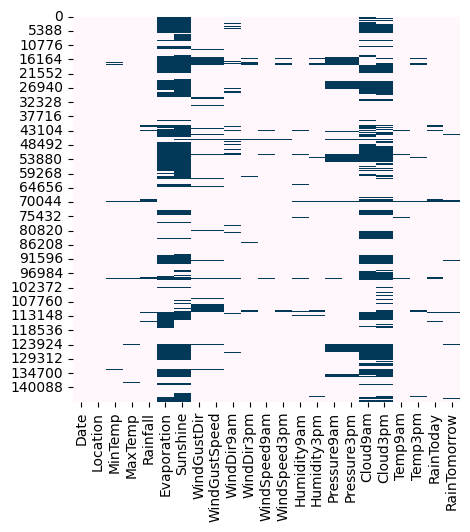

In [9]:
plt.figure(figsize=(5,5))
sns.heatmap(df.isnull(), cbar=False, cmap='PuBu')
plt.show()

From this plot we can understand that columns **Evaporation**, **Sunshine**, **Pressure3pm**, **Pressure9am**, **Cloud9am** and **Cloud3pm** contain a lot of NaN values. Other columns also contain them but in a smaller percentage.

Let's see the percentage of null values for each column.

In [10]:
# create a table with data missing 
missing_values = df.isnull().sum() # missing values

percent_missing = df.isnull().sum()/df.shape[0]*100 # missing value %

value = {
    'missing_values ':missing_values,
    'percent_missing %':percent_missing , 
     'data type' : df.dtypes
}
frame=pd.DataFrame(value)
frame

,missing_values,percent_missing %,data type
Date,0,0.000000,object
Location,0,0.000000,object
MinTemp,1485,1.020899,float64
MaxTemp,1261,0.866905,float64
Rainfall,3261,2.241853,float64
Evaporation,62790,43.166506,float64
Sunshine,69835,48.009762,float64
WindGustDir,10326,7.098859,object
WindGustSpeed,10263,7.055548,float64
WindDir9am,10566,7.263853,object


Now, we distinguish categorical and numerical features. In this we work separately with them.

In [11]:
categorical, contin=[],[]

for i in df.columns:
    
    if df[i].dtype == 'object':
        categorical.append(i)
    else:
        contin.append(i)
        
print(categorical)
print(contin)

['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']


Now, we explore problems on categorical features.

Missing values in categorical features:

In [12]:
(df[categorical].isnull().sum()/len(df[categorical]))

Date           0.000000
Location       0.000000
WindGustDir    0.070989
WindDir9am     0.072639
WindDir3pm     0.029066
dtype: float64

We can fill missing values in categorical features with the mode

In [13]:
for i in categorical:
    df[i].fillna(df[i].mode()[0], inplace=True)

And we convert them into continuous by using *LabelEncoder* function.

In [14]:
lencoders = {}
for col in df.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    df[col] = lencoders[col].fit_transform(df[col])

In [15]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,396,2,13.4,22.9,0.6,NaN,NaN,13,44.0,13,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0.0
1,397,2,7.4,25.1,0.0,NaN,NaN,14,44.0,6,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0.0
2,398,2,12.9,25.7,0.0,NaN,NaN,15,46.0,13,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,0.0
3,399,2,9.2,28.0,0.0,NaN,NaN,4,24.0,9,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0.0,0.0
4,400,2,17.5,32.3,1.0,NaN,NaN,13,41.0,1,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0.0


Now, we can consider problems in numerical features:

In [16]:
(df[contin].isnull().sum()/len(df[contin]))

MinTemp          0.010209
MaxTemp          0.008669
Rainfall         0.022419
Evaporation      0.431665
Sunshine         0.480098
WindGustSpeed    0.070555
WindSpeed9am     0.012148
WindSpeed3pm     0.021050
Humidity9am      0.018246
Humidity3pm      0.030984
Pressure9am      0.103568
Pressure3pm      0.103314
Cloud9am         0.384216
Cloud3pm         0.408071
Temp9am          0.012148
Temp3pm          0.024811
RainToday        0.022419
RainTomorrow     0.022460
dtype: float64

Since columns **RainToday** and **RainTomorrow** contain only $2$% of null values, I prefer to drop them.

In [17]:
df = df.dropna(subset=['RainToday', 'RainTomorrow'])

For the other values we use the **Multiple Imputation by Chained Equations (MICE)** of *Scikit-Learn* library. 

This is a strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion.
- You basically take the variable that contains missing values as a response $Y$ and other variables as predictors $X$.
- Build a model with rows where $Y$ is not missing
- Then predict the missing observations by using the trained model

Do this multiple times by doing random draws of the data and taking the mean of the predictions.

In [18]:
# Multiple Imputation by Chained Equations
mice_imputer = IterativeImputer(max_iter=1000)
df.iloc[:,:] = mice_imputer.fit_transform(df)

#for i in contin:
    #df[i].fillna(df[i].median(), inplace=True)

Final check

In [19]:
# create a table with data missing 
missing_values=df.isnull().sum() # missing values

percent_missing = df.isnull().sum()/df.shape[0]*100 # missing value %

value = {
    'missing_values ':missing_values,
    'percent_missing %':percent_missing , 
     'data type' : df.dtypes
}
frame=pd.DataFrame(value)
frame

,missing_values,percent_missing %,data type
Date,0,0.0,int64
Location,0,0.0,int64
MinTemp,0,0.0,float64
MaxTemp,0,0.0,float64
Rainfall,0,0.0,float64
Evaporation,0,0.0,float64
Sunshine,0,0.0,float64
WindGustDir,0,0.0,int64
WindGustSpeed,0,0.0,float64
WindDir9am,0,0.0,int64


Let's find **outliers**

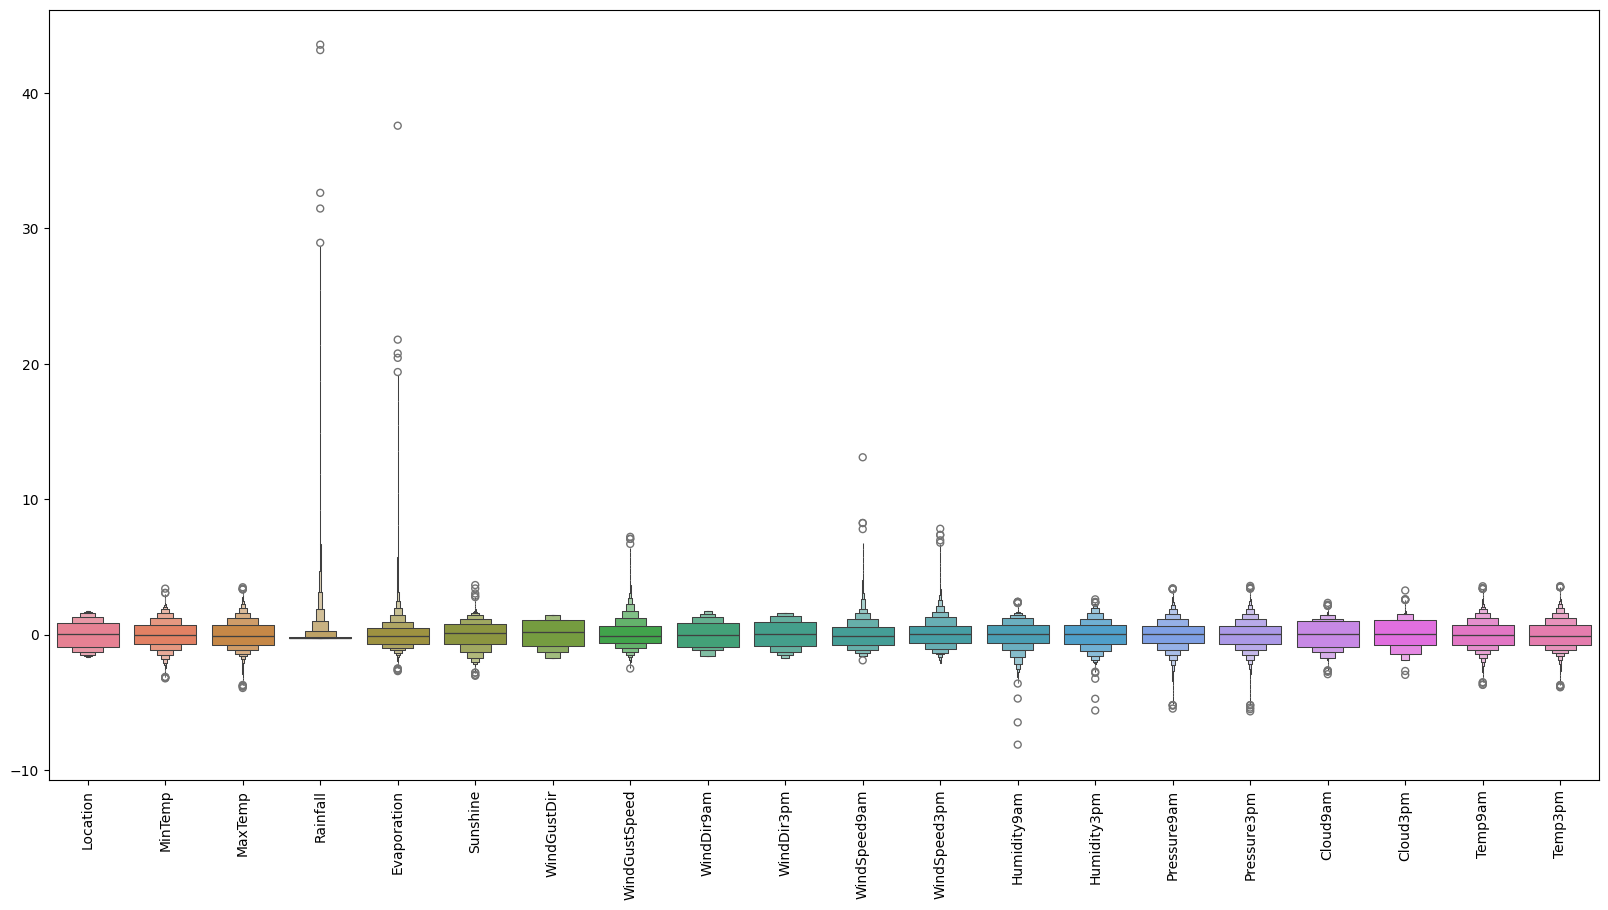

In [20]:
# Prepairing attributes of scale data

features = df.drop(['RainTomorrow','RainToday','Date'], axis=1) # dropping target and extra columns

# Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names) 


plt.figure(figsize=(20,10))
sns.boxenplot(data = features)
plt.xticks(rotation=90)
plt.show()

From this first chart we can see that, in particular, columns **Rainfall**, **Evaporation** and **WindSpeed9am** are caracterised with an high value of outliers.

Now, in order to fix outliers, we add three functions, which use $IQR$ method:
- **outlier_thresholds**: this function calculates, for the specific column of the dataset, its first and third quantile and the Interquantile Range. $IQR$ is defined as the range between the first quartile ($Q1$) and the third quartile ($Q3$) in a dataset. To find the boundaries for identifying potential outliers based on the $IQR$, a common rule of thumb is to consider values outside the range: 
$$[Q1 - 1.5 * IQR,\quad Q3 + 1.5 * IQR]$$

- **check_outliers**: this function verifies that in a specific column there are outliers by checking if there are values outside the previous range. It returns True if there are outliers in that specific column otherwise False

- **replace_with_thresholds**: a common practice is to replace outliers with the specific threshold. In particular, values that are lower than the lower bound are substituted with the lower bound and values that are bigger than the upper bound are replaced with the upper bound.

In [22]:
# Outlier Equation
def outlier_thresholds (dataframe, column, q1=0.25, q3=0.75) :
    quartile1 = dataframe[column].quantile(q1)
    quartile3 = dataframe[column].quantile(q3)
    interquartile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquartile_range
    low_limit = quartile1 - 1.5 * interquartile_range
    return low_limit, up_limit

# Checking Outliers
def check_outlier(dataframe, column):
    low_limit, up_limit = outlier_thresholds(dataframe, column)
    outliers = (dataframe[column] > up_limit) | (dataframe[column] < low_limit)
    if outliers.any():
        return True
    else:
        return False

# Replace with threshold
def replace_with_thresholds (dataframe, column) :
    low_limit , up_limit = outlier_thresholds(dataframe, column)
    dataframe.loc[(dataframe[column] < low_limit), column] = low_limit
    dataframe.loc[(dataframe[column] > up_limit), column] = up_limit

# Replace with median
def replace_with_median(dataframe, column):
    low_limit, up_limit = outlier_thresholds(dataframe, column)
    median_value = dataframe[column].mean()
    dataframe.loc[(dataframe[column] < low_limit), column] = median_value
    dataframe.loc[(dataframe[column] > up_limit), column] = median_value

In [23]:
print('Before removing the outliers :')
for column in (df.drop(columns = ['RainTomorrow', 'RainToday', 'Date', 'Location']).columns):
    print(column, check_outlier(df, column))

Before removing the outliers :
MinTemp True
MaxTemp True
Rainfall True
Evaporation True
Sunshine True
WindGustDir False
WindGustSpeed True
WindDir9am False
WindDir3pm False
WindSpeed9am True
WindSpeed3pm True
Humidity9am True
Humidity3pm True
Pressure9am True
Pressure3pm True
Cloud9am False
Cloud3pm False
Temp9am True
Temp3pm True


In [24]:
print('After removing the outliers :')
for column in (df.drop(columns = ['RainTomorrow', 'RainToday', 'Date', 'Location']).columns):
    replace_with_thresholds(df, column)
    print(column, check_outlier(df, column))

After removing the outliers :
MinTemp False
MaxTemp False
Rainfall False
Evaporation False
Sunshine False
WindGustDir False
WindGustSpeed False
WindDir9am False
WindDir3pm False
WindSpeed9am False
WindSpeed3pm False
Humidity9am False
Humidity3pm False
Pressure9am False
Pressure3pm False
Cloud9am False
Cloud3pm False
Temp9am False
Temp3pm False


Final check

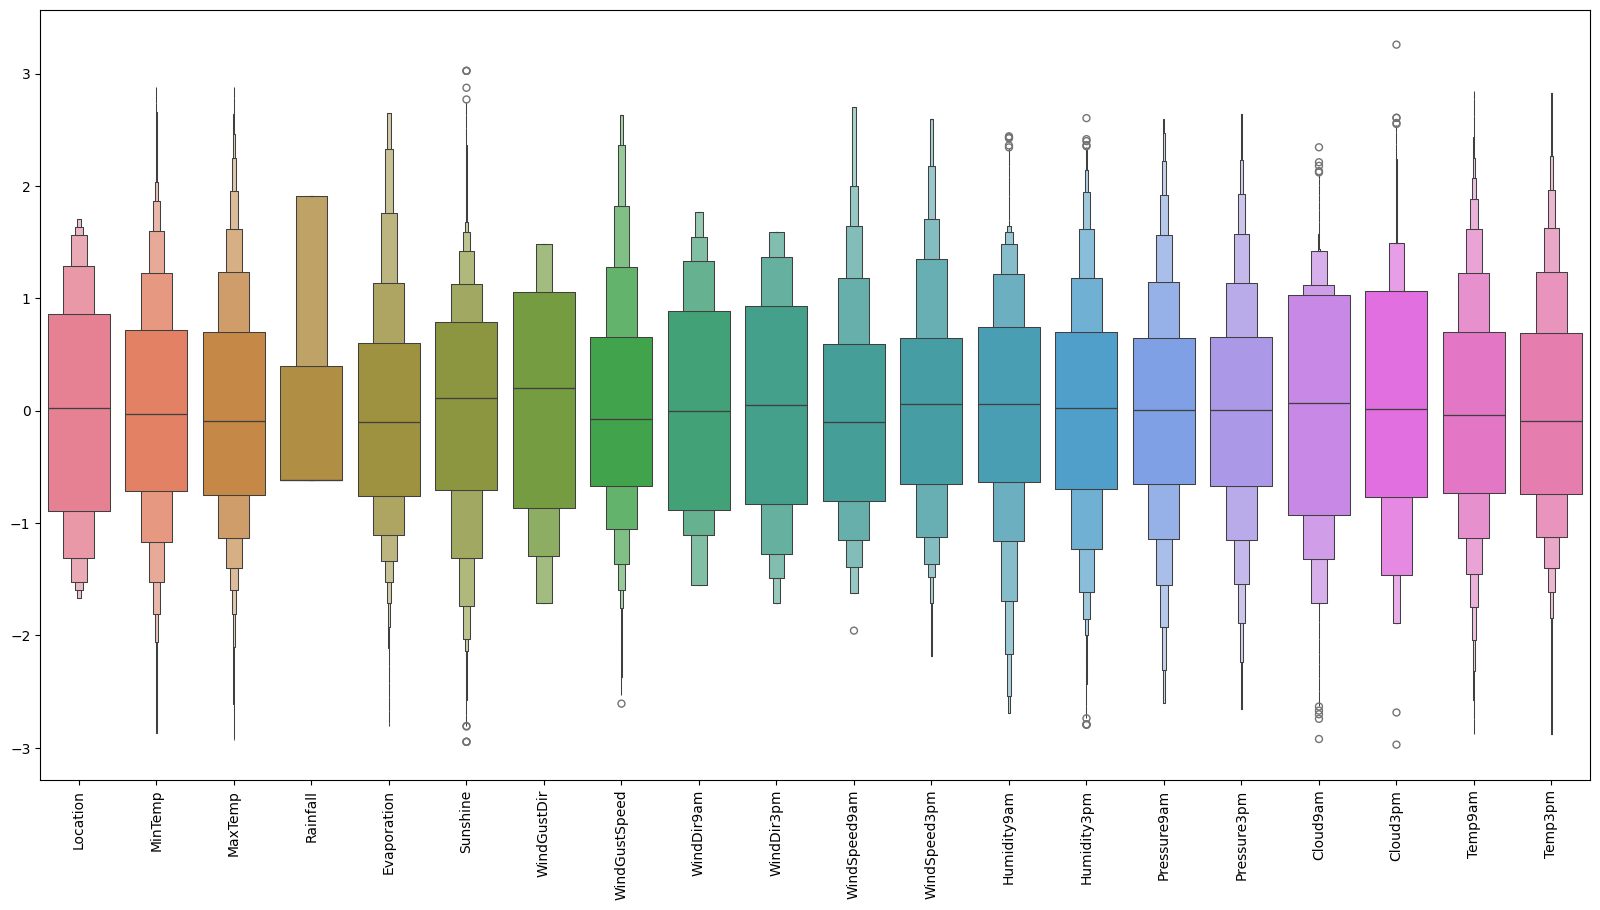

In [25]:
features = df.drop(['RainTomorrow','RainToday','Date'], axis=1) # dropping target and extra columns

# Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names) 

#Detecting outliers

plt.figure(figsize=(20,10))
sns.boxenplot(data = features)
plt.xticks(rotation=90)
plt.show()

Now, we try to explore **Multicollinearity problem**

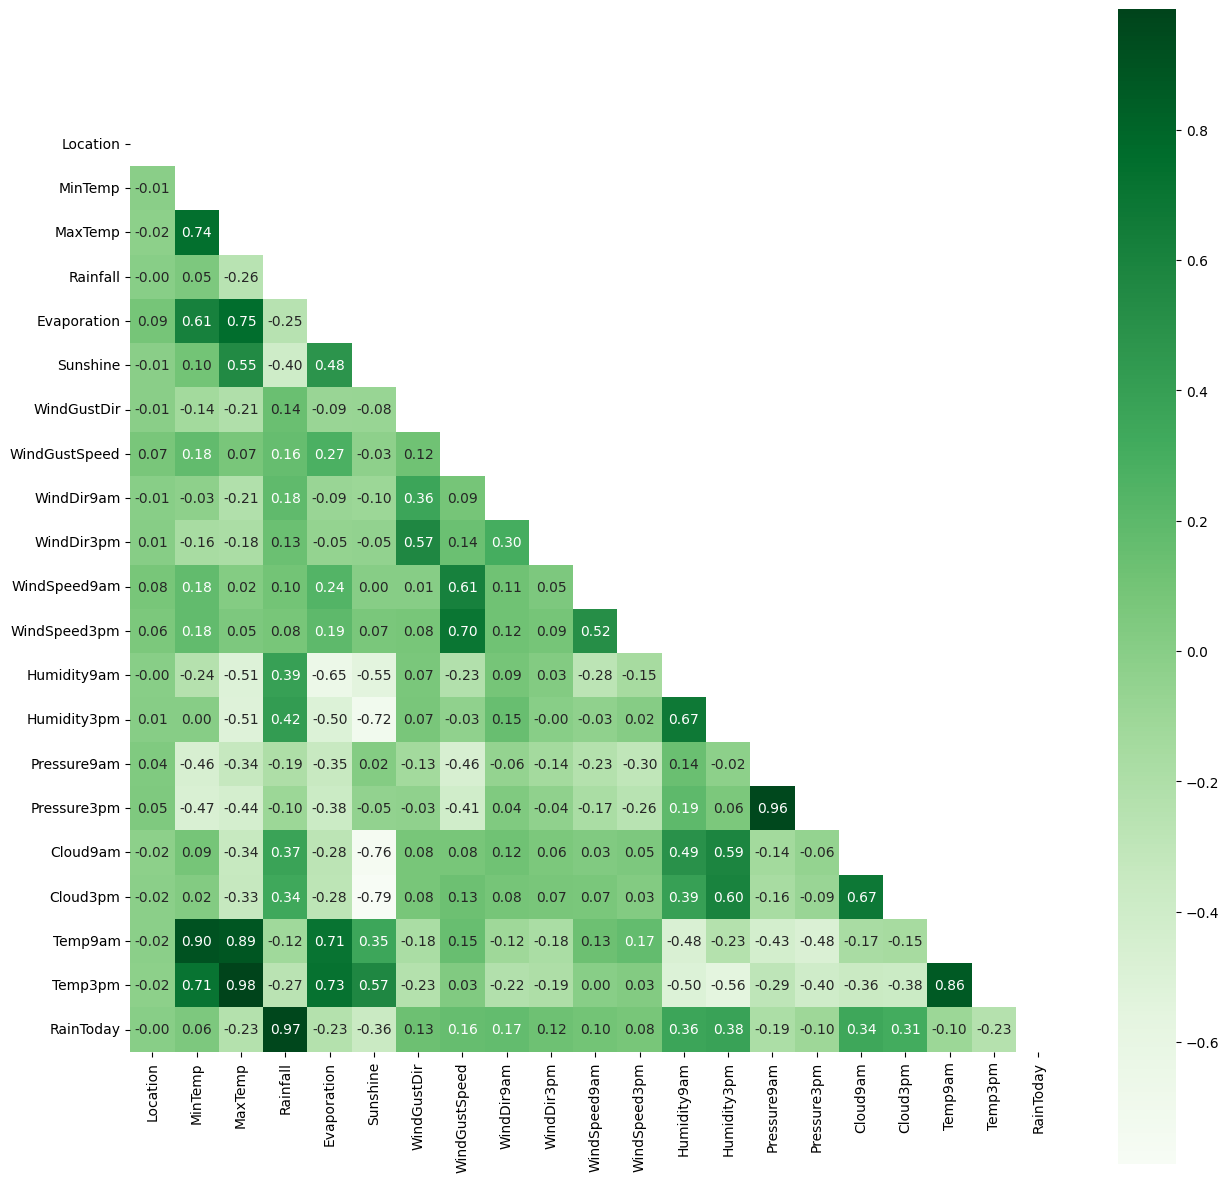

In [26]:
corr = df.drop(['RainTomorrow', 'Date'], axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(15,15))
ax = sns.heatmap(corr, mask=mask, square=True, annot=True, fmt='.2f', cmap='Greens')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

From the matrix we can observe that some features are higly correlated. 

So, we can adopt the **VIF** method or *Variance Inflaction Factor*. In VIF method, we pick each feature and regress it against all of the other features. For each regression, the factor is calculated as :
$$ VIF = \frac{1}{1 - R^2}$$
As we see from the formula, greater the value of $R^2$, greater is the $VIF$. Hence, greater $VIF$ denotes greater correlation.

In [27]:
# add a constant
X = add_constant(df.drop(['RainTomorrow'], axis=1))

# for each column we calculate the vif value
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


          feature           VIF
0           const  43000.933464
1            Date      1.019089
2        Location      1.048043
3         MinTemp     10.915623
4         MaxTemp     49.509326
5        Rainfall     16.580866
6     Evaporation      3.826661
7        Sunshine      5.563556
8     WindGustDir      1.626109
9   WindGustSpeed      3.057047
10     WindDir9am      1.296399
11     WindDir3pm      1.650072
12   WindSpeed9am      1.946910
13   WindSpeed3pm      2.283799
14    Humidity9am      4.634240
15    Humidity3pm      6.831019
16    Pressure9am     24.275623
17    Pressure3pm     23.138382
18       Cloud9am      2.941021
19       Cloud3pm      3.098813
20        Temp9am     23.135183
21        Temp3pm     55.815780
22      RainToday     15.481261


Now, step by step, we select the variable with the highest $VIF$ value and we remove it. In this way, we saw that deleting **Temp3pm**, **Temp9am**, **Pressure9am** and **Rainfall** features produced an important decrease.

In [28]:
df_reduced = df.drop(['Temp3pm', 'Pressure9am', 'Temp9am', 'Rainfall'], axis=1)

X_reduced = add_constant(df_reduced.drop(['RainTomorrow'], axis=1))
vif_data_reduced = pd.DataFrame()
vif_data_reduced["feature"] = X_reduced.columns
vif_data_reduced["VIF"] = [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]

print(vif_data_reduced)


          feature           VIF
0           const  40994.929955
1            Date      1.017247
2        Location      1.047645
3         MinTemp      5.633780
4         MaxTemp      8.086556
5     Evaporation      3.622636
6        Sunshine      5.388329
7     WindGustDir      1.609030
8   WindGustSpeed      2.967927
9      WindDir9am      1.275793
10     WindDir3pm      1.559342
11   WindSpeed9am      1.923658
12   WindSpeed3pm      2.205593
13    Humidity9am      2.857733
14    Humidity3pm      4.017702
15    Pressure3pm      1.686417
16       Cloud9am      2.897327
17       Cloud3pm      3.007988
18      RainToday      1.362563


So we can drop them

In [29]:
df.drop(['Temp3pm', 'Pressure9am', 'Temp9am', 'Rainfall'], axis=1, inplace=True)

# Machine Learning
Now we can focus our attention on predicting the target column **RainTomorrow** by using different ML algorithm.

In [30]:
df.drop('Date',axis = 1, inplace = True)

## Data Preprocessing

From the chart we can see that we have the problem of **IMBALANCED DATASET**.

This aspect is a problem in the field of Machine Learning because when we try to apply any prediction algorithm we will notice that it will predict the majority class well, but not the minority.

This is because the algorithm was trained on an instance that had a majority of 'NO' cases.

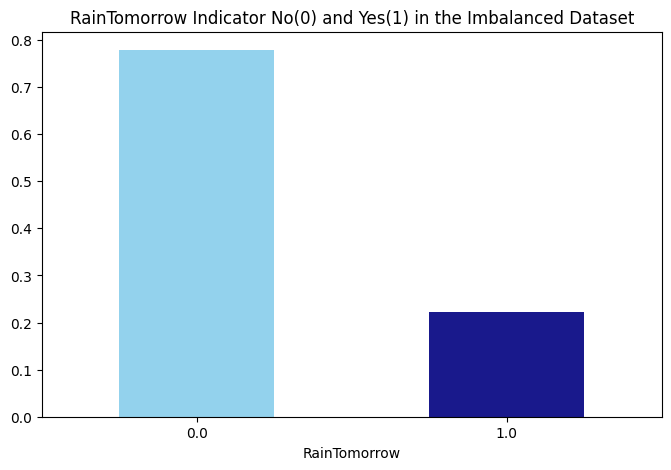

In [31]:
fig = plt.figure(figsize = (8,5))
df.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

In the scope of our MLOps project, we don't care. Now, we have to split the data into train and test set:

### Divide the data into train and test set

In [32]:
X = df.drop('RainTomorrow', axis = 1)
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=df['RainTomorrow'])

print('X_train size', X_train.shape)
print('y_train size', y_train.shape)
print('X_test size', X_test.shape)
print('y_test size', y_test.shape)

X_train size (105590, 17)
y_train size (105590,)
X_test size (35197, 17)
y_test size (35197,)


### Standardize them
By using *StandardScaler* we apply standardization.

In [33]:
# Standardize the original training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Model Evaluation Class
This class train and test the selected model and generates the most important metrics:
- **Accuracy**: it calculates the fraction of correct prediction
    $$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$
- **Precision**: in words, precision answers the question: "Out of all the instances predicted as positive by the model, how many were actually positive?". It is particularly important in situations where the cost of false positives (instances predicted as positive but are actually negative) is high, and you want to minimize the chances of making false positive predictions.
    $$Precision = \frac{TP}{TP + FP}$$
- **Recall**: in words, recall answers the question: "Out of all the actual positive instances, how many did the model correctly identify?". It is particularly important in situations where the cost of missing positive instances (false negatives) is high, and you want to minimize the chances of false negatives.
    $$Recall = \frac{TP}{TP + FN}$$
- **F1**: the F1 score provides a balance between precision and recall. It ranges from $0$ to $1$, where $1$ indicates perfect precision and recall, and $0$ indicates poor performance
    $$F1 = 2\times\frac{Precision \times Recall}{Precision \times Recall}$$

In [34]:
class Model:
    def __init__(self, model, name = None, scaled = True, resample = None):
        self.model = model
        self.name = name
        self.scaled = scaled
        self.resample = resample
    def fit(self):
        if self.scaled == True and self.resample == None:
            self.model.fit(X_train_scaled, y_train)
        if self.scaled == False and self.resample == None:
            self.model.fit(X_train, y_train)
        if self.scaled == True and self.resample == 'smote':
            self.model.fit(X_train_smote_scaled, y_train_smote)
        if self.scaled == False and self.resample == 'smote':
            self.model.fit(X_train_smote, y_train_smote)
        if self.scaled == True and self.resample == 'under':
            self.model.fit(X_train_under_scaled, y_train_under)
        if self.scaled == False and self.resample == 'under':
            self.model.fit(X_train_under, y_train_under)
    def __get_predictions(self):
        if self.scaled == True and self.resample == None:
            return self.model.predict(X_test_scaled), self.model.predict_proba(X_test_scaled)[:,1]
        if self.scaled == False and self.resample == None:
            return self.model.predict(X_test), self.model.predict_proba(X_test)[:,1]
        if self.scaled == True and self.resample == 'smote':
            return self.model.predict(X_test_smote_scaled), self.model.predict_proba(X_test_smote_scaled)[:,1]
        if self.scaled == False and self.resample == 'smote':
            return self.model.predict(X_test), self.model.predict_proba(X_test)[:,1]
        if self.scaled == True and self.resample == 'under':
            return self.model.predict(X_test_under_scaled), self.model.predict_proba(X_test_under_scaled)[:,1]
        if self.scaled == False and self.resample == 'under':
            return self.model.predict(X_test), self.model.predict_proba(X_test)[:,1]
    def get_metrics(self) -> pd.Series:
        y_pred, y_probs = self.__get_predictions()
        accuracy = metrics.accuracy_score(y_test, y_pred)
        precision = metrics.precision_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred)
        f1 = metrics.f1_score(y_test, y_pred)
        roc_auc = metrics.roc_auc_score(y_test, y_probs)
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        pr_auc = metrics.average_precision_score(y_test, y_probs)
        metrics_series = pd.Series({
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC AUC': roc_auc,
            'Confusion Matrix': conf_mat,
            'PR AUC': pr_auc,
            'Name': self.name
        })
        if self.name == '' or self.name is None:
            metrics_series.Name =type(self.model).__name__
        return metrics_series
    
    def visualize_metrics(self):
        y_pred, y_probs = self.__get_predictions()
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
        roc_auc = metrics.roc_auc_score(y_test, y_probs)
        # Calculate Precision-Recall curve and AUC
        precision, recall, _ = metrics.precision_recall_curve(y_test, y_probs)
        pr_auc = metrics.auc(recall, precision)
        # Plot ROC curve
        plt.figure(figsize=(20, 10))
        plt.subplot(2, 2, 1)
        plt.axis('equal')
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')

        # Plot Precision-Recall curve
        plt.subplot(2, 2, 2)
        plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='lower left')

        residuals = y_test - y_probs
        # Plot Confusion Matrix and Distribution of errors
        plt.subplot(2, 2, 3)
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Predicted 0', 'Predicted 1'],
                    yticklabels=['Actual 0', 'Actual 1'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.subplot(2, 2, 4)
        sns.histplot(residuals, bins=30, edgecolor='black', kde=True)
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.title('Distribution of Errors')
        plt.show()

In [35]:
models_df = pd.DataFrame(columns=['Name',
    'Accuracy',
    'Precision',
    'Recall',
    'F1-Score',
    'ROC AUC',
    'Confusion Matrix',
    'PR AUC'])


## Random Forest
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

### No Resample

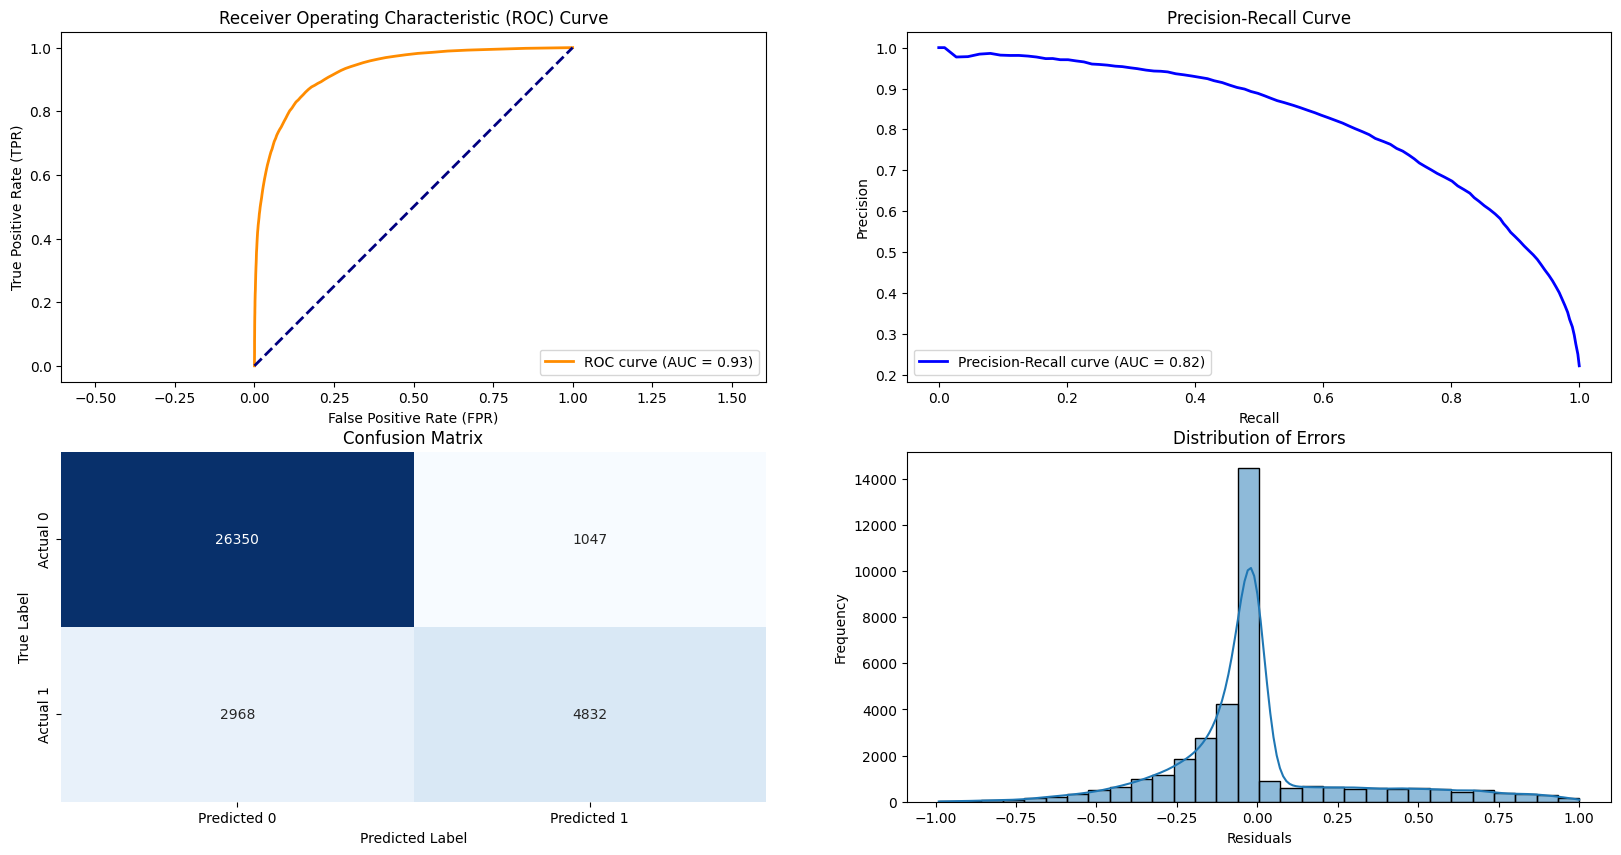

In [36]:
model = Model(RandomForestClassifier(), name='RF No Resample', scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [37]:
# Define parameters
n_estimators = 100
max_depth = 10

In [38]:
# Train model
params = {
    "n_estimators": n_estimators,
    "max_depth": max_depth,
    "random_state": 42,
}


In [39]:
rfc = RandomForestClassifier(**params)

In [40]:
rfc.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [43]:
# Evaluate model
y_pred = rfc.predict(X_test_scaled)
y_probs = rfc.predict_proba(X_test_scaled)[:,1]

In [46]:
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
roc_auc = metrics.roc_auc_score(y_test, y_probs)
conf_mat = metrics.confusion_matrix(y_test, y_pred)
pr_auc = metrics.average_precision_score(y_test, y_probs)

In [49]:
metrics_rfc = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'ROC AUC': roc_auc,
    'Confusion Matrix': conf_mat,
    'PR AUC': pr_auc,
    'Name': 'RFC No Resample'
}

In [50]:
metrics_rfc

{'Accuracy': 0.8730573628434242,
 'Precision': 0.8077207240487625,
 'Recall': 0.5606410256410257,
 'F1-Score': 0.661873770243681,
 'ROC AUC': np.float64(0.9093071438665846),
 'Confusion Matrix': array([[26356,  1041],
        [ 3427,  4373]]),
 'PR AUC': np.float64(0.7833552548701764),
 'Name': 'RFC No Resample'}